In [93]:
from typing import TypedDict, List, Annotated

from pydantic import BaseModel,Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send 

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [94]:
from dotenv import load_dotenv
load_dotenv()

True

In [95]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [96]:
class Task(BaseModel):
    id: int
    title: str
    brief : str = Field(...,description="What to do?")


In [97]:
class Plan(BaseModel):

    blog_title: str
    tasks : List[Task]

In [98]:
class State(TypedDict):

    topic: str
    plan: Plan
    sections : Annotated[List[str],operator.add]
    final : str

In [99]:
def orchestrator(state: State) -> dict:

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content = "Generate the 1-2 sections on the given topic"
            ),
            HumanMessage(content=f"The topic is {state['topic']}")
        ]
    )
    return {'plan':plan}

In [100]:
def fanout(state: State) -> dict:

    return [Send('worker',{'task': task, 'topic': state['topic'],'plan': state['plan']}) for task in state['plan'].tasks]

In [101]:
def worker(payload: dict) -> dict:

    task = payload['task']
    topic = payload['topic']
    plan = payload['plan']

    section = llm.invoke(
        [
            SystemMessage(content="Write a clean markdown section within 100 characters"),
            HumanMessage(
                content=(
                    f"Task: {task}"
                    f"topic: {topic}"
                    f"plan: {plan}"
                    "return section in markdown only"
                )
            )
        ]
    ).content.strip()


    return {'sections': [section]}

In [ ]:

from pathlib import Path

def reducer(state: State) -> dict:

    title = state['plan'].blog_title.strip()
    body = "\n\n".join(state['sections']).strip()

    final = f"{title}\n\n{body}"

    filename = "filename" + ".md"
    output_path = Path(filename)
    output_path.write_text(final,encoding='utf-8')

    return {'final': final}



In [103]:
Graph = StateGraph(State)

Graph.add_node('worker',worker)
Graph.add_node('orchestrator',orchestrator)
Graph.add_node('reducer',reducer)

In [104]:
Graph.add_edge(START,'orchestrator')
Graph.add_conditional_edges('orchestrator',fanout,['worker'])
Graph.add_edge('worker','reducer')
Graph.add_edge('reducer',END)

app = Graph.compile()

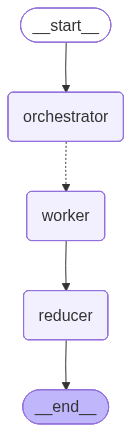

In [105]:
app

In [106]:
out = app.invoke({'topic': "write a blog on Girls"})

In [107]:
print(out['final'])

Celebrating Girls: Nurturing Potential, Inspiring Futures

### The Unyielding Spirit: Celebrating the Strengths of Girls

## Nurturing Potential: Empowering Girls
Support their education, self-esteem, and leadership.
